In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def TDMA(a, b, c, d):
  nmax = len(d)#n em números é linhas

  # Modifica o primeiro coeficiente de cada linha
  c[0] /= b[0] #Risco de divisão por zero.
  d[0] /= b[0]

  for i in range(1, nmax):
    ptemp = b[i] - (a[i] * c[i-1])
    c[i] /= ptemp
    d[i] = (d[i] - a[i] * d[i-1])/ptemp

  #Substituição de volta
  x = [0 for i in range(nmax)]
  x[-1] = d[-1]
  for i in range(-2,-nmax-1,-1):
    x[i] = d[i] - c[i] * x[i+1]
  return x

def norma_maximo(aprox, exata):
  return max(abs(exata - aprox))

def taxaconvergencia(erro, numpoints):
  taxa = []
  for i in range(0, len(numpoints)-1):
      taxa.append(abs(np.log2(erro[i+1]) - np.log2(erro[i])) / (np.log2(numpoints[i+1]) - np.log2(numpoints[i])))
  return np.mean(taxa)

def novataxa(erro, numpoints):
  return (np.log2(erro[1]) - np.log2(erro[0])) / (np.log2(numpoints[1]) - np.log2(numpoints[0]))

#Questão 1


In [ ]:
def sol_exata(x, t, delta):
  return (1/2)*(1 - np.tanh((x-(2*t/delta))/delta))

def fonte(u, delta):
  return (8/(delta**2))*(u**2)*(1-u)

In [ ]:
def implicito_segundaordemh(numph,  x, delta, Time, dtfactor):
  dh = 100/numph #discretização do espaço
  u = np.zeros(numph + 1)
  dt = dh*dtfactor

  #condição inicial
  u = sol_exata(x, 0, delta)

  #dominio temporal
  time = 0
  timeit = 0
  eps = 1 #coeficiente de difusão
  sigma = eps*dt/(dh*dh)
  while(time < Time):
    u[0] = sol_exata(x[0], time, delta)
    u[numph] = sol_exata(x[numph], time, delta)

    diagonal1 = - sigma*np.ones(numph-1)
    diagonal2 = (1 + 2*sigma)*np.ones(numph-1)
    diagonal3 = - sigma*np.ones(numph-1)

    d = fonte(u[1:numph], delta)*dt + u[1:numph]

    d[0] = d[0] + sigma*u[0]
    d[numph-2] = d[numph-2] + sigma*u[numph]

    u[1:numph] = TDMA(diagonal1, diagonal2, diagonal3, d)
    time += dt
    timeit +=1

  print("Passos no tempo: " + str(timeit))

  return u

In [ ]:
def leapfrog(numph, x, delta, Time, dtfactor):
  dh = 100/numph #discretização do espaço
  u = np.zeros(numph + 1)
  oldu = np.zeros(numph + 1)

  dt = dh*dtfactor

  #dominio temporal

  eps = 1 #coeficiente de difusão
  #aproximação do primeiro passo de tempo:
  ndt = dt**2
  timeit = 0
  time = 0
  u1 = sol_exata(x, 0, delta)
  while(time < dt):
    #Implícito
    u1[0] = sol_exata(x[0], time, delta)
    u1[numph] = sol_exata(x[numph], time, delta)
    sigma = ndt*eps/(dh**2)
    diagonal1 = -sigma*np.ones(numph-1)
    diagonal2 = (1+2*sigma)*np.ones(numph-1)
    diagonal3 = -sigma*np.ones(numph-1)

    d = fonte(u1[1:numph], delta)*ndt + u1[1:numph]

    d[0] = d[0] + sigma*u1[0]
    d[numph-2] = d[numph-2] + sigma*u1[numph]
    u1[1:numph] = TDMA(diagonal1, diagonal2, diagonal3, d)
    time += ndt
    timeit += 1


  oldu = sol_exata(x, 0, delta) #enquanto o u1 armazena a posição u1, a oldu armazena a posição u0
  sigma = eps*dt*2/(dh*dh)
  u = u1.copy()

  #a partir de n = 1 (por que assim, aproxima-se n=2 com n=0 e n=1)
  while(time < Time):
    #condições de contorno no espaço no passo n+1
    u[0] = sol_exata(x[0], time, delta)
    u[numph] = sol_exata(x[numph], time, delta)

    #matriz tridiagonal
    diagonal1 = -sigma*np.ones(numph-1) #j-1
    diagonal2 = (1 + 2*sigma)*np.ones(numph-1) #j
    diagonal3 = -sigma*np.ones(numph-1) #j+1

    #utiliza-se u^n para alimentar a fonte não linear e soma-se o passo u^{n-1}
    d = (fonte(u1[1:numph], delta)*2*dt) + oldu[1:numph]

    #condições de contorno do espaço no passo n+1
    d[0] = d[0] + sigma*u[0]
    d[numph-2] = d[numph-2] + sigma*u[numph]

    #resolução do passo n+1
    u[1:numph] = TDMA(diagonal1, diagonal2, diagonal3, d)

    #u^n-1 = u^n
    oldu = u1.copy()
    #u^n = u^n+1
    u1 = u.copy()

    time += dt
    timeit += 1

  print("Passos no tempo: " + str(timeit))

  return u, dt

In [ ]:
erros = []
nels = []
delta = 2
numph = 2000 #discretização do espaço

x = np.linspace(-10,90, numph + 1)
exata = sol_exata(x, 4, delta)
u, dt=leapfrog(numph, x, delta, Time=4, dtfactor=100/numph)
plt.plot(x,u,"-+", label= "Diferença Central")
plt.legend()

u = implicito_segundaordemh(numph,x, delta, Time=4, dtfactor=1)
erros.append(norma_maximo(u, exata))
nels.append(4/dt)
plt.plot(x, u, "-o", label = "Primeira ordem")
plt.legend()
plt.plot(x, exata, label = "Exata")
#plt.legend()

print(norma_maximo(u, exata))

''' numph = 4000 #discretização do espaço

x = np.linspace(-10,90, numph + 1)
exata = sol_exata(x, 4, delta)
u, dt=leapfrog(numph, x, delta, Time=4, dtfactor=1)
erros.append(norma_maximo(u, exata))
nels.append(4/dt)
plt.plot(x, u, '-*')
plt.plot(x,exata)
print(norma_maximo(u, exata))
plt.show() '''

'''
print(novataxa(erros, nels))
plt.plot(np.log10(nels), np.log10(erros), "-x")
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()
 '''
#o leap frog começa a ser segunda ordem depois de 2000 elementos do espaço

Implícito segunda ordem h
Passos no tempo: 20
0.05005529187365021
Passos no tempo: 40
0.025693222363317336
Passos no tempo: 81
0.002541265026840933
Passos no tempo: 161
0.0012766587856370415
Passos no tempo: 320
0.0032864123924194466
Taxa de convergência: [0.9621347597859913, 3.337769093813405, 0.9931738554873171, 1.3641405414431276]
Implícito segunda ordem h²
Passos no tempo: 100
0.010958451253887225
Passos no tempo: 401
0.00048685775088938565
Passos no tempo: 1601
0.0001218645764429066


KeyboardInterrupt: ignored

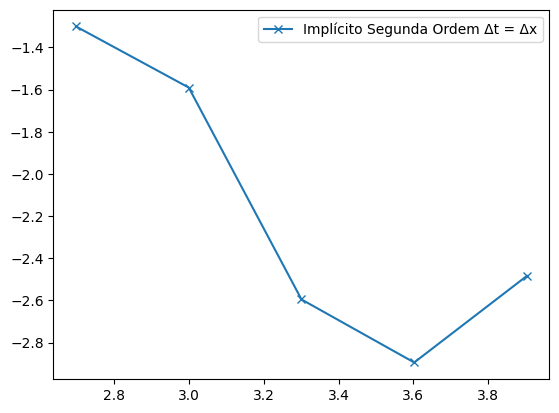

In [ ]:
erros = []
nels = []
delta = 2
numph = [500,1000,2000,4000,8000] #discretização do espaço

print("Implícito segunda ordem h")
for i in range(len(numph)):
  x = np.linspace(-10,90, numph[i]+1)
  exata = sol_exata(x, 4, delta)
  u = implicito_segundaordemh(numph[i], x, delta, Time=4, dtfactor=1)
  print(norma_maximo(u, exata))
  erros.append(norma_maximo(u, exata))
  nels.append(numph[i])

print("Taxa de convergência: " + str(taxaconvergencia(erros, nels)))
plt.plot(np.log10(nels), np.log10(erros), "-x", label="Implícito Segunda Ordem Δt = Δx")
plt.legend()

erros.clear()
nels.clear()

print("Implícito segunda ordem h²")
for i in range(len(numph)):
  x = np.linspace(-10,90, numph[i]+1)
  exata = sol_exata(x, 4, delta)
  u = implicito_segundaordemh(numph[i], x, delta, Time=4, dtfactor=100/numph[i])

  print(norma_maximo(u, exata))
  erros.append(norma_maximo(u, exata))
  nels.append(numph[i])

print("Taxa de convergência: " + str(taxaconvergencia(erros, nels)))
plt.plot(np.log10(nels), np.log10(erros), "-x", label="Implícito Segunda Ordem Δt = Δx²")
plt.legend()

erros.clear()
nels.clear()

print("Diferença Central h")
for i in range(len(numph)):
  x = np.linspace(-10,90, numph[i]+1)
  exata = sol_exata(x, 4, delta)
  u , dt= leapfrog(numph[i], x, delta, Time=4, dtfactor=1)
  print(norma_maximo(u, exata))
  erros.append(norma_maximo(u, exata))
  nels.append(numph[i])

print("Taxa convergência: "  + str(taxaconvergencia(erros, nels)))
plt.plot(np.log10(nels), np.log10(erros), "-x", label="Diferença central Δt = Δx")
plt.legend()

erros.clear()
nels.clear()

print("Diferença Central h²")
for i in range(len(numph)):
  x = np.linspace(-10,90, numph[i]+1)
  exata = sol_exata(x, 4, delta)
  u , dt= leapfrog(numph[i], x, delta, Time=4, dtfactor=100/numph[i])
  print(norma_maximo(u, exata))

  erros.append(norma_maximo(u, exata))
  nels.append(numph[i])

print("Taxa convergência: "  + str(taxaconvergencia(erros, nels)))
plt.plot(np.log10(nels), np.log10(erros), "-x", label="Diferença central Δt = Δx")
plt.legend()
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()

''' numph = 4000 #discretização do espaço

x = np.linspace(-10,90, numph + 1)
exata = sol_exata(x, 4, delta)
u, dt=leapfrog(numph, x, delta, Time=4, dtfactor=1)
erros.append(norma_maximo(u, exata))
nels.append(4/dt)
plt.plot(x, u, '-*')
plt.plot(x,exata)
print(norma_maximo(u, exata))
plt.show() '''

'''
print(novataxa(erros, nels))
plt.plot(np.log10(nels), np.log10(erros), "-x")
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()
 '''
#o leap frog começa a ser segunda ordem depois de 2000 elementos do espaço

Diferença Central dt = h
Passos no tempo: 79
0.0018657925122241847
Diferença Central dt = h²
Passos no tempo: 3200
4.854246821184294e-05
Taxa convergência: [0.9891898552671423]


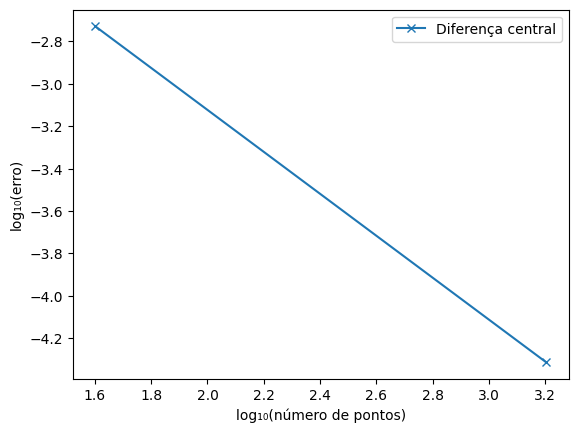

In [ ]:
erros = []
nels = []
delta = 2
numph = 4000 #discretização do espaço
print("Diferença Central dt = h")
x = np.linspace(-10,90, numph+1)
exata = sol_exata(x,1, delta)
u , dt= leapfrog(numph, x, delta, Time=1, dtfactor=1)
print(norma_maximo(u, exata))

erros.append(norma_maximo(u, exata))
nels.append(1/dt)

print("Diferença Central dt = h²")
x = np.linspace(-10,90, numph+1)
exata = sol_exata(x, 1, delta)
u , dt= leapfrog(numph, x, delta, Time=1, dtfactor=100/numph)
print(norma_maximo(u, exata))
erros.append(norma_maximo(u, exata))
nels.append(1/dt)

print("Taxa convergência: "  + str(taxaconvergencia(erros, nels)))
plt.plot(np.log10(nels), np.log10(erros), "-x", label="Diferença central")
plt.legend()
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()


In [ ]:
erros = [0.015142416575295914,0.0018602228595155923 , 0.00046656726663596437  ,0.00011673687326438364 ,2.9190168260584404e-05  ]
numph = [100,401,1601,6401,25601] #discretização do espaço
print(taxaconvergencia(erros, numph))

1.1271251964576727


#Segunda questão

In [ ]:
def BackFTCS(numph, x, Time, solinicial, kappa):
  dh = 1/numph
  u = solinicial(x, 0)
  dt = dh
  print(u)
  time = 0
  ro = (kappa*dt)/(2*dh)
  oldu = u.copy()
  while(time < Time):
    u[0] = solinicial(x[0], time)
    u[numph] = solinicial(x[numph], time)

    diagonal1 = -ro*np.ones(numph-2)
    diagonal2 = (1+(2*ro))*np.ones(numph-1)
    diagonal3 = ro*np.ones(numph-2)

    d = oldu[1:numph]

    d[0] = d[0] + ro*solinicial(x[0], time)
    d[numph-2] = d[numph-2] - ro*solinicial(x[numph], time)
    u[1:numph] = np.linalg.solve(np.diag(diagonal1, k=-1) + np.diag(diagonal2, k=0) + np.diag(diagonal3, k=1), d) # (diagonal1, diagonal2, diagonal3, d)

    time+=dt

  return u

In [ ]:
def upwind_explicito(numph, x, Time, solinicial):
  dh = 1/numph #discretização do espaço
  u = np.zeros(numph + 1)

  dt = dh/2

  #condição inicial
  old_u = solinicial(x,0)

  #tempo inicial
  time = 0
  kappa = 1.0 #coeficiente de convecção

  ro = (kappa*dt)/(dh)

  while(time < Time):
    if(kappa > 0 ):
      for i in range(numph):
        u[i]  = old_u[i] - ro*(old_u[i] - old_u[i-1])
    elif(kappa < 0):
      for i in range(numph):
        u[i]  = old_u[i] - ro*(old_u[i+1] - old_u[i])
    old_u = u.copy()
    time+= dt

  return u



In [ ]:
def laxFriedrich(numph, x, Time, solinicial):
  dh = 1/numph #discretização do espaço
  u = np.zeros(numph + 1)

  dt = dh/2

  #condição inicial
  old_u = 2*solinicial(x,0)

  #tempo inicial
  time = 0
  kappa = 1.0 #coeficiente de convecção

  ro = (kappa*dt)/(dh)

  while(time < Time):
    for i in range(numph):
      u[i]  = (0.5)*(old_u[i-1]+u[i+1]) - (ro/2)*(old_u[i+1] - old_u[i-1])
    old_u = u.copy()
    time+= dt
  return u



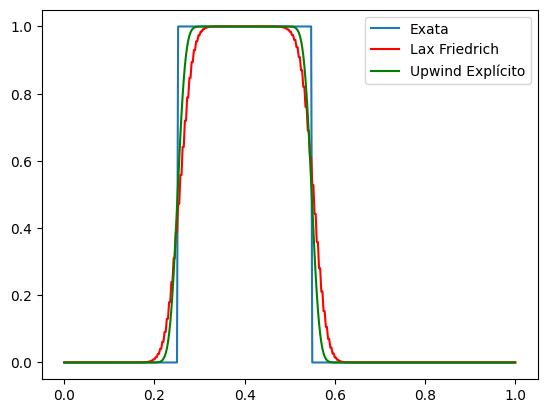

In [ ]:
kappa = 1.0

def condcontorn( x, t):
  if isinstance(x, np.ndarray):
    # Se x for um array, aplicamos a condição em cada elemento do array.
    u = np.where((x > 0.1+t) & (x < 0.4+t)  , 1, 0)
  else:
    # Se x for um valor único, aplicamos a condição diretamente.
    u = 1 if (x > 0.1+t) & (x < 0.4+t) else 0
  return u

numph = 400
x = np.linspace(0 , 1, numph+1)
Time = 0.15
plt.plot(x, condcontorn(x,Time), label = "Exata")


u = laxFriedrich(numph, x, Time=Time, solinicial=condcontorn)
plt.plot(x, u, color="red", label = "Lax Friedrich")
plt.legend()


u = upwind_explicito(numph, x, Time=Time, solinicial=condcontorn)
plt.plot(x, u, color="green", label = "Upwind Explícito")
plt.legend()

plt.show()

#Terceira Questão


In [ ]:
def solExatas(x, t, eps, kappa):
  return np.exp(-eps*t)*np.sin(x - (kappa*t))

In [247]:
def upwindimplicito(numph, x, Time, solinicial, eps, kappa, dtfactor):
  dh = 1/numph #discretização do espaço
  u = np.zeros(numph + 1)
  #condição inicial
  u = solinicial(x, 0, eps, kappa)
  dt = dh**dtfactor

  #tempo inicial
  time = 0

  ro = (kappa*dt)/(dh)
  sigma = (eps*dt)/(dh**2)

  if(kappa > 0):
    while(time < Time):
      u[0] = solinicial(x[0], time, eps, kappa)
      u[numph] = solinicial(x[numph], time, eps, kappa)
      diagonal1 = (-ro-sigma)*np.ones(numph-1) #j-1
      diagonal2 = (1+(2*sigma)+ro)*np.ones(numph-1) #j
      diagonal3 = (-sigma)*np.ones(numph-1) #j+1

      d = u[1:numph] #ujn só

      d[0] = d[0] + (solinicial(x[0], time, eps, kappa) *(sigma+ro))
      d[numph-2] = d[numph-2]  + solinicial(x[numph], time, eps, kappa)*(sigma)
      u[1:numph] = TDMA(diagonal1, diagonal2, diagonal3, d)
      time += dt
  elif(kappa <= 0):
    while(time < Time):
      u[0] = solinicial(x[0], time, eps, kappa)
      u[numph] = solinicial(x[numph], time, eps, kappa)
      diagonal1 = (-sigma)*np.ones(numph-1) #j-1
      diagonal2 = (1+(2*sigma)-ro)*np.ones(numph-1) #j
      diagonal3 = (ro-sigma)*np.ones(numph-1) #j+1

      d = u[1:numph] #ujn só

      d[0] = d[0] + (solinicial(x[0], time, eps, kappa) *(sigma))
      d[numph-2] = d[numph-2]  + (solinicial(x[numph], time, eps, kappa)*(sigma-ro))
      u[1:numph] = TDMA(diagonal1, diagonal2, diagonal3, d)
      time += dt



  return u,dh


In [246]:
def conveccaodiferencacentral(numph, x, Time, solinicial, eps, kappa, dtfactor):
  dh = 1/numph #discretização do espaço
  u = np.zeros(numph + 1)
  #condição inicial
  u = solinicial(x, 0, eps, kappa)
  dt = dh**dtfactor

  #tempo inicial
  time = 0

  ro = (kappa*dt)/(2*dh) #convectivo
  sigma = (eps*dt)/(dh**2) #difusivo

  # if(kappa > 0):
  while(time < Time):
    u[0] = solinicial(x[0], time, eps, kappa)
    u[numph] = solinicial(x[numph], time, eps, kappa)

    diagonal1 = (-sigma-ro)*np.ones(numph-1) #j-1
    diagonal2 = (1+(2*sigma))*np.ones(numph-1) #j
    diagonal3 = (-sigma+ro)*np.ones(numph-1) #j+1

    d = u[1:numph] #ujn só

    d[0] = d[0] + (solinicial(x[0], time, eps, kappa) *(sigma+ro))
    d[numph-2] = d[numph-2]  + solinicial(x[numph], time, eps, kappa)*(sigma-ro)
    u[1:numph] = TDMA(diagonal1, diagonal2, diagonal3, d)
    time += dt

  return u, dh


0.025


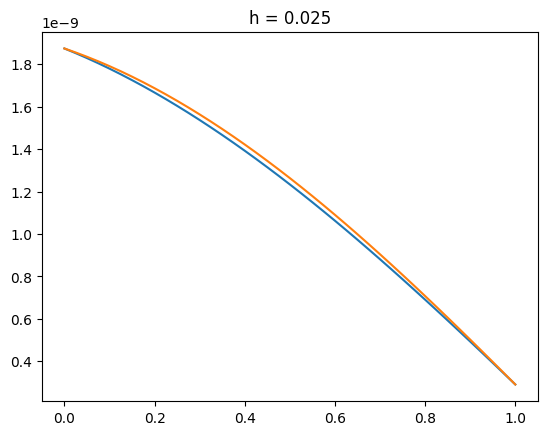

In [248]:
numph = 40
x = np.linspace(0 , 1, numph+1)
Time = 2
eps = 10
kappa = -1
plt.plot(x, solExatas(x, Time, eps, kappa))
u, dh = conveccaodiferencacentral(numph, x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa, dtfactor= 1)
print(dh)
plt.title("h = " + str(dh))
plt.plot(x,u)

Taxa convergência: 1.6103084939074066
Taxa convergência: 1.8925332445672047


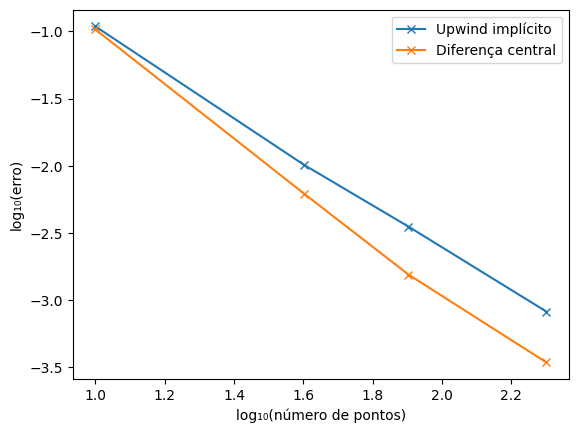

In [244]:
numph = [10,40,80,200]
erros = []
for i in range(len(numph)):
  x = np.linspace(0 , 1, numph[i]+1)
  Time = 2
  eps = 0
  kappa = 10
  u, dh = upwindimplicito(numph[i], x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa, dtfactor= 1)
  erros.append(norma_maximo(u,  solExatas(x, Time, eps, kappa)))
print("Taxa convergência: "  + str(taxaconvergencia(erros, numph)))
plt.plot(np.log10(numph), np.log10(erros), "-x", label="Upwind implícito")

erros.clear()
for i in range(len(numph)):
  x = np.linspace(0 , 1, numph[i]+1)
  Time = 2
  eps = 0
  kappa = 10
  u, dh = conveccaodiferencacentral(numph[i], x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa,  dtfactor= 1)
  erros.append(norma_maximo(u,  solExatas(x, Time, eps, kappa)))
print("Taxa convergência: "  + str(taxaconvergencia(erros, numph)))
plt.plot(np.log10(numph), np.log10(erros), "-x", label="Diferença central")
plt.legend()
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()


Taxa convergência: 1.0005745018669463
Taxa convergência: 1.0005745018669463


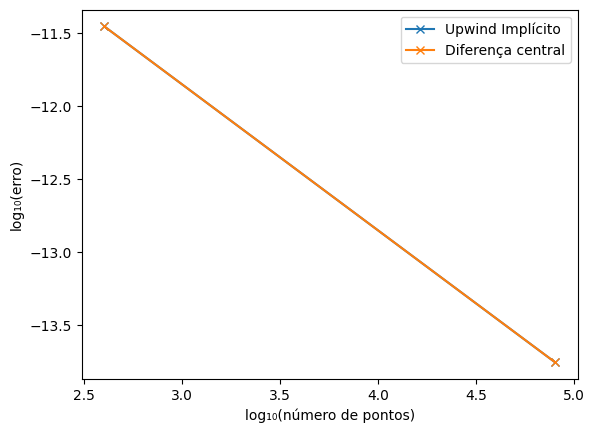

In [256]:
erros = []
ndt = []
i = 3

x = np.linspace(0 , 1, numph[i]+1)
Time = 2
eps = 10
kappa = 0
u, dh = upwindimplicito(numph[i], x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa, dtfactor= 1)
erros.append(norma_maximo(u,  solExatas(x, Time, eps, kappa)))
ndt.append(2/dh)

x = np.linspace(0 , 1, numph[i]+1)
Time = 2
eps = 10
kappa = 0
u, dh = upwindimplicito(numph[i], x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa, dtfactor= 2)
erros.append(norma_maximo(u,  solExatas(x, Time, eps, kappa)))
ndt.append(2/(dh**2))
print("Taxa convergência: "  + str(taxaconvergencia(erros, ndt)))
plt.plot(np.log10(ndt), np.log10(erros), "-x", label="Upwind Implícitow")

erros.clear()
ndt.clear()


x = np.linspace(0 , 1, numph[i]+1)
Time = 2
eps = 10
kappa = 0
u, dh = conveccaodiferencacentral(numph[i], x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa, dtfactor= 1)
erros.append(norma_maximo(u,  solExatas(x, Time, eps, kappa)))
ndt.append(2/dh)

x = np.linspace(0 , 1, numph[i]+1)
Time = 2
eps = 10
kappa = 0
u, dh = conveccaodiferencacentral(numph[i], x, Time=Time, solinicial=solExatas, eps=eps, kappa=kappa, dtfactor= 2)
erros.append(norma_maximo(u,  solExatas(x, Time, eps, kappa)))
ndt.append(2/(dh**2))
print("Taxa convergência: "  + str(taxaconvergencia(erros, ndt)))
plt.plot(np.log10(ndt), np.log10(erros), "-x", label="Diferença central")

plt.legend()
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()